In [7]:
import numpy as np
from scipy import optimize
from scipy.optimize import minimize, minimize_scalar
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
N=50

np.random.seed(4444)

alpha = np.random.uniform(low=0.1,high=0.9,size=N)
beta = np.random.uniform(low=0.1,high=0.9,size=N)
e1 =np.random.uniform(low=0,high=1,size=N)
e2 =np.random.uniform(low=0,high=1,size=N)

In [9]:
#Utility at initial distribution

u_initial = []

for i in range(N):
    u_initial.append(u(e1[i],e2[i],alpha[i]))

In [10]:
#Utility with production but no trade

u_koopman = []
z_ = []
z = 0

for i in range(N):
    bounds = [(0,e1[i])]
    result = minimize(lambda z: -u_koop(e1[i],e2[i],z,alpha[i],beta[i]),z,
                      method="SLSQP",bounds=bounds,options={'ftol': 1e-9})
    z_.append(result.x[0])
    u_koopman.append(-result.fun)

In [11]:
#Utility with trade but no production

p=1
def excessdemand_fun(e1,e2,p,alpha):
    x1 = []
    for i in range(N):
        I = e1[i]*p + e2[i]
        x1.append(demand1(alpha[i],I,p))
    return abs(excessdemand1(e1,x1))

bounds=[(1e-9,np.inf)]
result = minimize(lambda p: excessdemand_fun(e1,e2,p,alpha),p,
                  method="SLSQP", bounds=bounds,options={'ftol': 1e-9})
print(result)

p1_fin = result.x[0]

u_trade = []
for i in range(N):
    I = e1[i]*p1_fin + e2[i]
    x1 = demand1(alpha[i],I,p1_fin)
    x2 = demand2(alpha[i],I)
    u_trade.append(u(x1,x2,alpha[i]))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.1051960175100248e-10
       x: [ 1.541e+00]
     nit: 10
     jac: [ 5.619e+00]
    nfev: 48
    njev: 10


In [12]:
#defining nested optimizer for utility in koopman with trade

def clear(alpha,beta,e1,e2,p1):
   
    #Maximizing income
    s=0
    I = []
    s_ = []

    for i in range(N):
        bounds=[(0,e1[i])]
        result = minimize(lambda s: -income(s,p1,e1[i],e2[i],beta[i]),s
                          ,method="SLSQP", bounds=bounds,options={'ftol': 1e-9})
        I.append(-result.fun)
        s_.append(result.x[0])

    #Demand
    x1 = []
    x2 = []
    for i in range(N):
        x1.append(demand1(alpha[i],I[i],p1))
        x2.append(demand2(alpha[i],I[i]))

    #Excess demand
    return abs(excessdemand1(e1,x1))

In [13]:
#utility in koopman with trade

p1=1
result = minimize(lambda p1: clear(alpha,beta,e1,e2,p1),p1,
                  method="SLSQP",bounds=[(0,np.inf)])
print(result)

p1_fin = result.x[0]

s=0
I = []
#s_ = []

for i in range(N):
    bounds=[(0,e1[i])]
    result = minimize(lambda s: -income(s,p1_fin,e1[i],e2[i],beta[i]),s,
                      method="SLSQP", bounds=bounds,options={'ftol': 1e-9})
    I.append(-result.fun)
    #s_.append(result.x[0])

#Demand
#x1 = []
#x2 = []
u_all = []
for i in range(N):
    x1 = demand1(alpha[i],I[i],p1_fin)
    x2 = demand2(alpha[i],I[i])
    u_all.append(u(x1,x2,alpha[i]))


c:\Users\Bruger\OneDrive\Skrivebord\Pogramming\git\projects-2024-rune-co\modelproject\modelproject.py:20: RuntimeWarning: divide by zero encountered in divide
  return alpha*I/p1


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.7357074710844245e-07
       x: [ 2.167e+00]
     nit: 10
     jac: [-4.445e+00]
    nfev: 37
    njev: 10


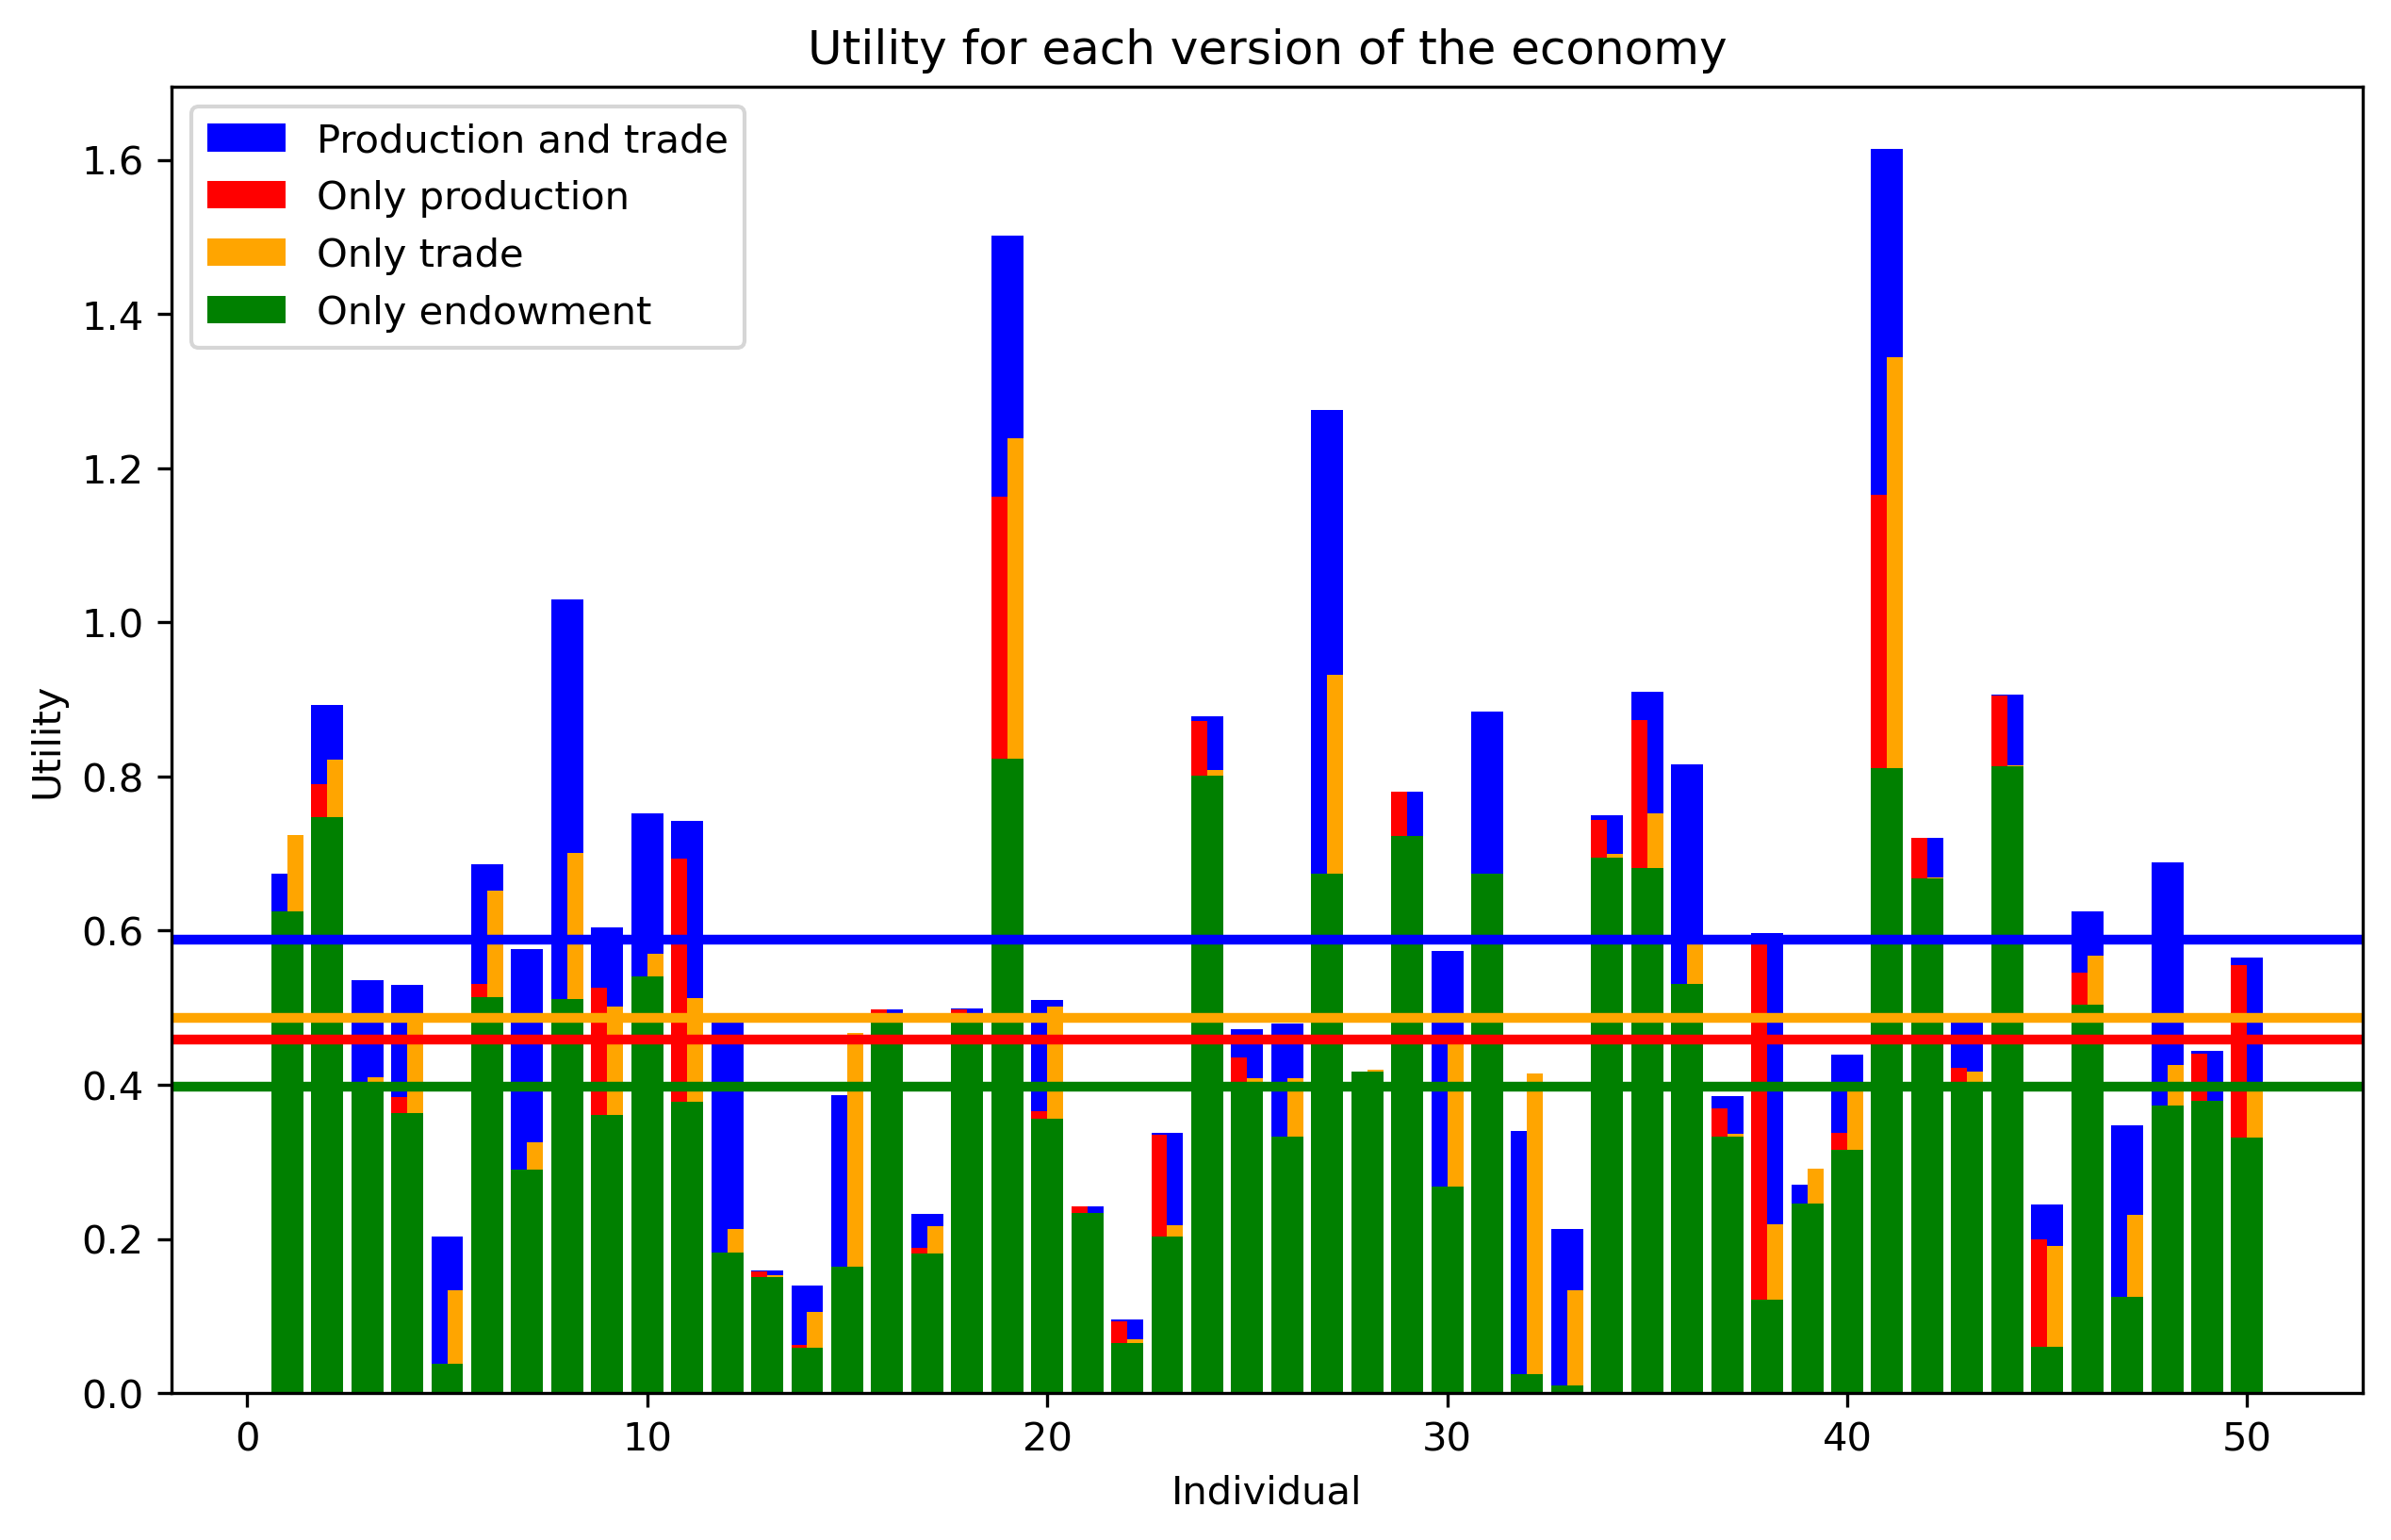

In [17]:
avg_u_initial = np.mean(u_initial)
avg_u_koopman = np.mean(u_koopman)
avg_u_trade = np.mean(u_trade)
avg_u_all   = np.mean(u_all)

r = np.arange(N) + 1
r1 = r - 0.2
r2 = r + 0.2
barWidth = .8
halfbar = .4

plt.figure(figsize=(10, 6), dpi=300) 

plt.bar(r, u_all, color='b', width=barWidth, label='Production and trade')
plt.bar(r1, u_koopman, color='r', width=halfbar, label='Only production')
plt.bar(r2, u_trade, color='orange', width=halfbar, label='Only trade')
plt.bar(r, u_initial, color='g', width=barWidth, label='Only endowment')

linewidth = 2.5
plt.axhline(y=avg_u_trade,   color='orange', linestyle='-', linewidth=linewidth)
plt.axhline(y=avg_u_koopman, color='r', linestyle='-', linewidth=linewidth)
plt.axhline(y=avg_u_all, color='b', linestyle='-', linewidth=linewidth)
plt.axhline(y=avg_u_initial, color='g', linestyle='-', linewidth=linewidth)

plt.title("Utility for each version of the economy")
plt.ylabel("Utility")
plt.xlabel("Individual")
plt.legend(loc="best")